In [50]:
import pandas as pd
from mvdata import TickerData
import yfinance as yf

def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()
    actions.columns = ["Date", ticker + "_Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    decision = []
    previous_decision = ""
    
    for value in actions[ticker + "_Signal"].values.tolist():
        if value == previous_decision:
            decision.append("Hold")
        else:
            decision.append(value)
            previous_decision = value
    
    actions[ticker + "_Signal"] = decision
    actions = actions.drop(["Date"],axis=1)

    return actions

df = TickerData("AAPL TSLA MSFT CORT").get_historical_data()
window = 50

rolling_mean = df.rolling(window=window).mean()
rolling_std = df.rolling(window=window).std()

buy_signal = df < rolling_mean - (2 * rolling_std)
sell_signal = df >= rolling_mean + (2 * rolling_std)

ticker_action = pd.DataFrame(df.index)

for tick in df.columns.tolist():
    print(action_tickers(tick,buy_signal,sell_signal))

# date = ticker_action.pop("Date")
# ticker_action = ticker_action.set_index(date)

[*********************100%%**********************]  4 of 4 completed

     AAPL_Signal
0           Hold
1           Hold
2           Hold
3           Hold
4           Hold
...          ...
1166        Hold
1167        Hold
1168        Hold
1169        Hold
1170        Hold

[1171 rows x 1 columns]
     CORT_Signal
0           Hold
1           Hold
2           Hold
3           Hold
4           Hold
...          ...
1166        Hold
1167        Hold
1168        Hold
1169        Hold
1170        Hold

[1171 rows x 1 columns]
     MSFT_Signal
0           Hold
1           Hold
2           Hold
3           Hold
4           Hold
...          ...
1166        Hold
1167        Hold
1168        Hold
1169        Hold
1170        Hold

[1171 rows x 1 columns]
     TSLA_Signal
0           Hold
1           Hold
2           Hold
3           Hold
4           Hold
...          ...
1166        Hold
1167        Hold
1168        Hold
1169        Hold
1170        Hold

[1171 rows x 1 columns]


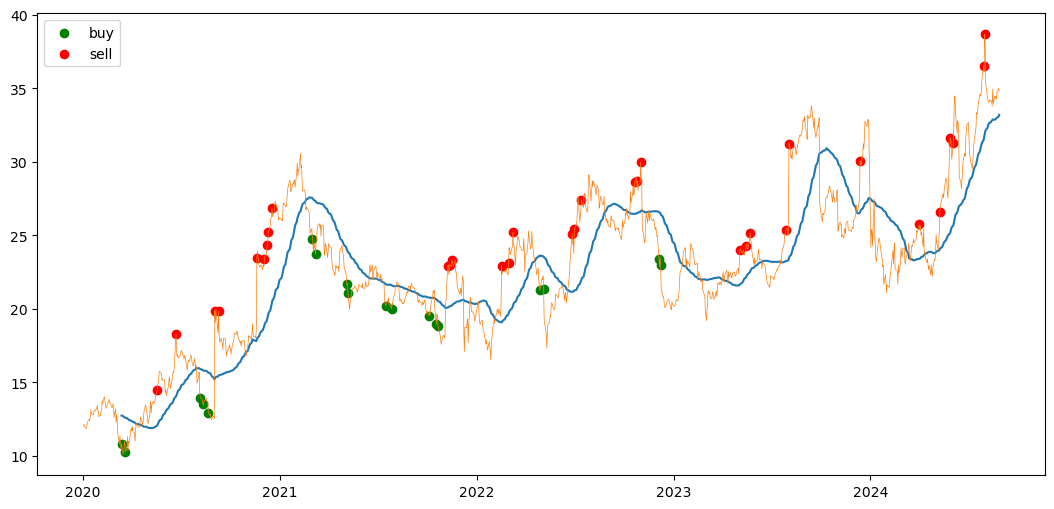

In [41]:
from matplotlib import pyplot as plt

figure, ax = plt.subplots(figsize=(13, 6))

plot_data = pd.concat([df,ticker_action],axis=1)

plt.plot(rolling_mean["CORT"])

buy = plot_data.loc[plot_data["CORTSignal"] == "Buy", ["CORT", "CORTSignal"]]
sell = plot_data.loc[plot_data["CORTSignal"] == "Sell", ["CORT", "CORTSignal"]]

plt.plot(plot_data["CORT"],linewidth=.5)

ax.scatter(buy.index,buy["CORT"],color="green",label="buy")
ax.scatter(sell.index,sell["CORT"],color="red",label="sell")

plt.legend()
plt.show()

sellTailAction
0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

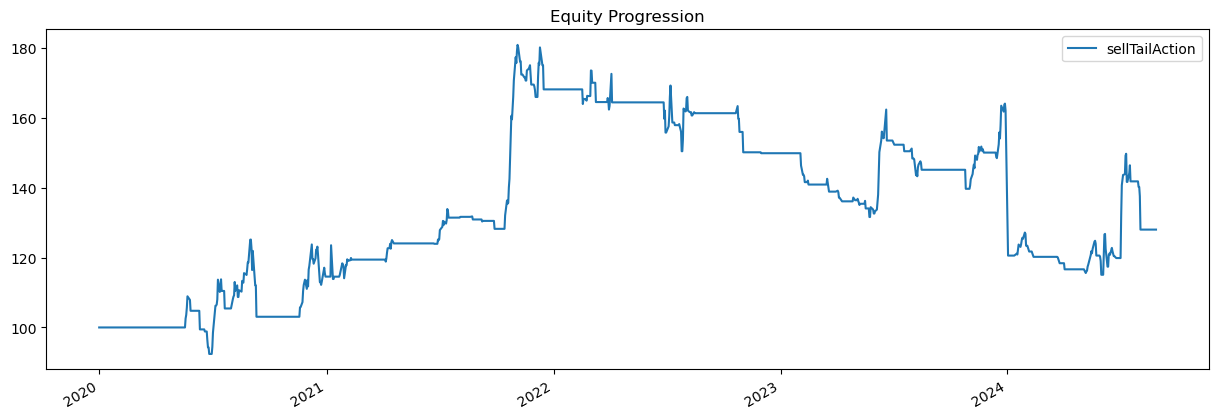

In [42]:
import bt

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                        bt.algos.RunAfterDays(window),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df,integer_positions=False, progress_bar=True)

res = bt.run(t2)
res.plot()

In [10]:
sell_signal

Ticker,AAPL,MSFT,TSLA
Date,,,
2020-01-02,False,False,False
2020-01-03,False,False,False
2020-01-06,False,False,False
2020-01-07,False,False,False
2020-01-08,False,False,False
...,...,...,...
2024-08-21,False,False,False
2024-08-22,False,False,False
2024-08-23,False,False,False


<Axes: title={'center': 'Equity Progression'}>

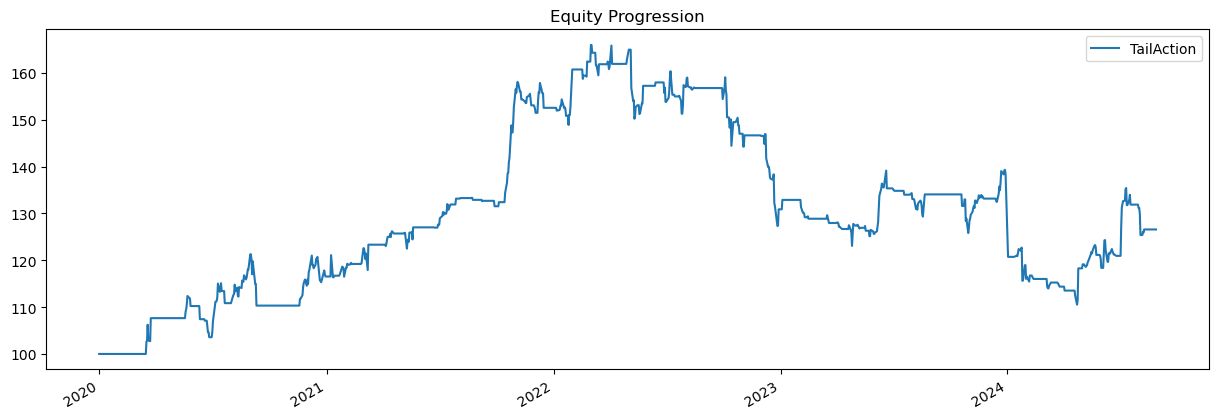

In [43]:
strat1 = bt.Strategy('buyTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.RunAfterDays(window),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t1 = bt.Backtest(strat1,df,integer_positions=False, progress_bar=True)

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                        bt.algos.RunAfterDays(window),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df,integer_positions=False, progress_bar=True)

tests = [t1,t2]

combined_strat = bt.Strategy('TailAction', [bt.algos.SelectAll(),
                                            bt.algos.RunAfterDays(window),
                                            bt.algos.WeighEqually(),
                                            bt.algos.Rebalance()],
                                            children = [x.strategy for x in tests])

combined_test = bt.Backtest(
    combined_strat,
    df,
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

res.plot()

In [44]:
res.display()

Stat                 TailAction
-------------------  ------------
Start                2020-01-01
End                  2024-08-27
Risk-free rate       0.00%

Total Return         26.58%
Daily Sharpe         0.40
Daily Sortino        0.57
CAGR                 5.19%
Max Drawdown         -33.42%
Calmar Ratio         0.16

MTD                  -3.48%
3m                   4.48%
6m                   9.11%
YTD                  -8.58%
1Y                   -5.58%
3Y (ann.)            -1.61%
5Y (ann.)            5.19%
10Y (ann.)           -
Since Incep. (ann.)  5.19%

Daily Sharpe         0.40
Daily Sortino        0.57
Daily Mean (ann.)    6.30%
Daily Vol (ann.)     15.58%
Daily Skew           -1.68
Daily Kurt           32.58
Best Day             6.03%
Worst Day            -12.81%

Monthly Sharpe       0.39
Monthly Sortino      0.63
Monthly Mean (ann.)  6.61%
Monthly Vol (ann.)   17.16%
Monthly Skew         -0.25
Monthly Kurt         3.16
Best Month           16.05%
Worst Month          -16.19%


In [2]:
import yfinance as yf
import pandas as pd

# Define the tickers for the comparable companies and the target company
comps_tickers = ['AAPL', 'MSFT', 'GOOGL']  # Example comparable companies
target_ticker = 'GDDY'  # Example target company

# Retrieve financial data for the comparable companies
def get_financial_data(tickers):
    financials = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        # Get the necessary financial data
        market_cap = stock.info['marketCap']
        revenue = stock.financials.loc['Total Revenue'][0]
        ebitda = stock.financials.loc['EBITDA'][0]
        financials.append({
            'Ticker': ticker,
            'Market Cap': market_cap,
            'Revenue': revenue,
            'EBITDA': ebitda
        })
    return pd.DataFrame(financials)

# Get financial data for comparable companies
comps_data = get_financial_data(comps_tickers)

# Calculate key financial ratios for comparable companies
comps_data['EV/Revenue'] = comps_data['Market Cap'] / comps_data['Revenue']
comps_data['EV/EBITDA'] = comps_data['Market Cap'] / comps_data['EBITDA']

# Retrieve financial data for the target company
target_data = get_financial_data([target_ticker])

# Display the data
print("Comparable Companies Data:")
print(comps_data)

print("\nTarget Company Data:")
print(target_data)

# Calculate the target company's implied valuation based on comps' multiples
ev_to_revenue_avg = comps_data['EV/Revenue'].mean()
ev_to_ebitda_avg = comps_data['EV/EBITDA'].mean()

target_revenue = target_data['Revenue'].values[0]
target_ebitda = target_data['EBITDA'].values[0]

implied_ev_revenue = target_revenue * ev_to_revenue_avg
implied_ev_ebitda = target_ebitda * ev_to_ebitda_avg

print(f"\nImplied Enterprise Value based on EV/Revenue multiple: ${implied_ev_revenue:,.2f}")
print(f"Implied Enterprise Value based on EV/EBITDA multiple: ${implied_ev_ebitda:,.2f}")


Comparable Companies Data:
  Ticker     Market Cap       Revenue        EBITDA  EV/Revenue  EV/EBITDA
0   AAPL  3572538540032  3.832850e+11  1.291880e+11    9.320841  27.653796
1   MSFT  3465314304000  2.119150e+11  1.051400e+11   16.352379  32.959048
2  GOOGL  2343618215936  3.073940e+11  9.797100e+10    7.624151  23.921550

Target Company Data:
  Ticker   Market Cap       Revenue       EBITDA
0   GDDY  20348987392  4.254100e+09  754100000.0

Implied Enterprise Value based on EV/Revenue multiple: $47,216,781,105.46
Implied Enterprise Value based on EV/EBITDA multiple: $21,249,128,824.76


In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import pairwise_distances_argmin_min

# Define the tickers and industries
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'BABA', 'JPM']
industries = ['Technology', 'Technology', 'Technology', 'Consumer Discretionary', 
              'Communication Services', 'Consumer Discretionary', 'Communication Services', 
              'Technology', 'Consumer Discretionary', 'Financials']

# Retrieve stock price data
def get_stock_price(tickers):
    prices = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        price = stock.history(period="1d")['Close'][0]
        prices.append(price)
    return prices

# Get stock prices
prices = get_stock_price(tickers)

# Create a DataFrame
data = pd.DataFrame({
    'Ticker': tickers,
    'Industry': industries,
    'Price': prices
})

# Preprocess the data
encoder = OneHotEncoder()
industry_encoded = encoder.fit_transform(data[['Industry']]).toarray()
price_scaled = StandardScaler().fit_transform(data[['Price']])

# Combine the encoded industry and scaled price
features = pd.DataFrame(industry_encoded).join(pd.DataFrame(price_scaled))

# Perform K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
data['Cluster'] = kmeans.fit_predict(features)

# Function to find the closest tickers
def find_closest_tickers(ticker, data, features, k=5):
    ticker_index = data[data['Ticker'] == ticker].index[0]
    cluster = data.loc[ticker_index, 'Cluster']
    cluster_data = data[data['Cluster'] == cluster]
    cluster_features = features.iloc[cluster_data.index]
    
    closest_indices, _ = pairwise_distances_argmin_min([features.iloc[ticker_index]], cluster_features)
    
    # Exclude the input ticker and get the closest k tickers
    closest_tickers = cluster_data.iloc[closest_indices].loc[cluster_data.index != ticker_index]['Ticker'].head(k).values
    return closest_tickers

# Example usage
target_ticker = 'AAPL'
closest_tickers = find_closest_tickers(target_ticker, data, features)
print(f"The five closest tickers to {target_ticker} are: {closest_tickers}")


In [ ]:
def find_closest_tickers(ticker, data, k=5):
    ticker_index = data[data['Ticker'] == ticker].index[0]
    cluster = data.loc[ticker_index, 'Cluster']
    cluster_data = data[data['Cluster'] == cluster]
    cluster_features = features.loc[cluster_data.index]

    closest_indices, _ = pairwise_distances_argmin_min([features.loc[ticker_index]], cluster_features)
    closest_tickers = cluster_data.iloc[closest_indices[1:k+1]]['Ticker'].values
    return cluster_features

find_closest_tickers("AAPL", data)

In [25]:
# import json
# import requests
# import os
# import yfinance as yf

# criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

# tickers = list(criteria["Portfolio Weights"].keys())

# for stock_ex in criteria["Exchanges"]:
#     github_branch = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main"
#     exchange =  "/" + stock_ex + "/" + stock_ex + "_full_tickers.json" 

#     url = github_branch + exchange # combining the repository dataset with the specific exchange

#     resp = requests.get(url)
#     data = json.loads(resp.text)

#     for i in range(len(data)):
#         ticker = data[i]

#         immediate_criteria = list(criteria["Immediate Criteria"].keys()) # ["lastsale", "volume", "marketCap"]
        
#         # important to note that since the list of tickers is massive, need to find any method to narrow scope

#         # Step 1: Check to see if anything is blank from the full json file or ticker already in portfolio
#         if ticker["symbol"] in tickers or any(ticker[checker] == "" for checker in immediate_criteria): 
#             continue

#         # numeric comparison
#         lastsale = float(ticker[immediate_criteria[0]][1:])
#         volume = float(ticker[immediate_criteria[1]])
#         marketCap = float(ticker[immediate_criteria[2]])

#         # Step 2: eliminate low cost stocks, less volume, and bound the marketcap due to portfolio size
#         check_1 = lastsale > criteria["Immediate Criteria"][immediate_criteria[0]] \
#             and volume > criteria["Immediate Criteria"][immediate_criteria[1]]
            
#         check_2 = marketCap <= criteria["Immediate Criteria"][immediate_criteria[2]]

#         if check_1 and check_2:
#             greater = criteria["Portfolio Criteria"]["Greater"]
#             less_than = criteria["Portfolio Criteria"]["Less Than"]

#             symbol = ticker["symbol"]

#             # list of metrics for criteria
#             metrics = list(greater.keys())
#             metrics.extend(list(less_than.keys()))

#             values = dict(filter(lambda item: item[0] in metrics, yf.Ticker(symbol).info.items()))
            
#             try:
#                 # Step 3: select tickers whick satisfy all of these conditions
#                 check_3 = all(values[metric] > x for metric,x in greater.items()) 
#                 check_4 = all(values[metric] < x for metric,x in less_than.items())
#                 if check_3 and check_4:
#                     tickers.append(symbol)

#             except KeyError:
#                 continue

# print(tickers)




    # def shortlist_tickers(self):
    #     tickers = RecommendTicker().get_all_tickers()
    #     new_tickers = []

    #     crit = list(Criteria().get_immediate_criteria().keys())

    #     for stock_ex in self.exchanges:
    #         data = tickers[stock_ex]

    #         ticker_data = []
    #         metric_data = {metric: [] for metric in crit}

    #         for tick_val in data:
    #             check_1 = tick_val["symbol"] in list(Basket().get_portfolio().keys())
    #             check_2 = any(tick_val[checker] == "" for checker in crit)

    #             if check_1 or check_2:
    #                 continue
                
    #             lastsale = float(tick_val[crit[0]][1:])
    #             volume = float(tick_val[crit[1]])
    #             marketCap = float(tick_val[crit[2]])

    #             ticker_data.append(tick_val["symbol"])
                
    #             # loop unrolling to save time here
    #             metric_data[crit[0]].append(lastsale)
    #             metric_data[crit[1]].append(volume)
    #             metric_data[crit[2]].append(marketCap)
                        
    #         metric_arrays = {metric: np.array(values) for metric, values in metric_data.items()}
            
    #         check_3 = np.ones(len(ticker_data), dtype=bool)
    #         check_4 = np.ones(len(ticker_data), dtype=bool)

    #         check_3 &= metric_arrays[crit[0]] > criteria["Immediate Criteria"][crit[0]]
    #         check_3 &= metric_arrays[crit[1]] > criteria["Immediate Criteria"][crit[1]]

    #         check_4 &= metric_arrays[crit[2]] < criteria["Immediate Criteria"][crit[2]]

    #         final_check = check_3 & check_4

    #         ticker_data = np.array(ticker_data)[final_check].tolist()

    #         new_tickers.extend(ticker_data)
        
    #     new_tickers = [tick.replace("/",".") for tick in new_tickers if "^" not in tick]

    #     return new_tickers



# criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

# class Criteria:
#     def __init__(self):
#         self.greater = criteria["Portfolio Criteria"]["Greater"]
#         self.less_than = criteria["Portfolio Criteria"]["Less Than"]
    
#     def get_immediate_criteria(self):
#         return criteria["Immediate Criteria"]
    
#     def get_greater_criteria(self):
#         return self.greater

#     def get_less_criteria(self):
#         return self.less_than
    
#     def get_metrics(self):
#         metrics = list(self.greater.keys())
#         metrics.extend(list(self.less_than.keys()))
#         return metrics

# yoy_dataset = pd.DataFrame()

        # if "yoy_value" in list(sub_data.columns):
        #     sub_data["yoy_value"] = sub_data["yoy_value"].str.replace("[,%)]","",regex=True)
        #     sub_data["yoy_value"] = sub_data["yoy_value"].str.replace("(","-")
            
        #     date1 = sub_data["date"].drop_duplicates().tolist()[0]

        #     sub_data.loc[sub_data["date"] == date1, "yoy_value"] = 0
        #     sub_data["yoy_value"] = sub_data["yoy_value"].replace("-", np.nan)

        #     sub_data["yoy_value"] = sub_data["yoy_value"].astype(float)/100

        #     yoy_dataset = pd.concat([yoy_dataset,sub_data[["account","date","yoy_value"]]])

# yoy_values = pd.DataFrame(index=yoy_dataset["account"].drop_duplicates().tolist(),
#                           columns=yoy_dataset["date"].drop_duplicates().tolist())

    # yoy_values[date] = yoy_dataset.loc[values_dataset["date"] == date, "yoy_value"].values
    # yoy_values[date] = yoy_values[date].fillna(0) 

# yoy_dataset = yoy_dataset.reset_index(drop=True)



# class Basket:
#     def __init__(self):
#         pass
        
#     def get_portfolio(self):
#         requires proper connectivity to the Interactive Brokers site first
#         will have to be from a json file and we will have to not query too often from there but just enough
#         pass
    
#     def update_portfolio(self, key: str, value: float):
#         values = list(self.portfolio.values())
#         if value <= 0:
#             raise ValueError("To add to portfolio, the ticker weight must be greater than 0")
#         elif sum(values) + value > 1:
#             raise ValueError("Max for current portfolio is " + str(1-sum(values)) + " based on current portfolio.")            
#         elif key in list(self.portfolio.keys()):
#             self.portfolio.update({key: value})
#         else:
#             self.portfolio[key] = value
            
#     def remove_ticker(self, key: str):
#         try:
#             del self.portfolio[key]
#         except KeyError:
#             print("This ticker was not in the portfolio.")




# only applicable after I use the code for retrieving market data and refer to TickerData class
# class PortfolioAnalytics:
#     def __init__(self):
#         self.portfolio = Basket().get_portfolio()
#         pass
    
#     def portfolio_data(self):
#         tick = ""

#         for ticker in list(self.portfolio.keys()):
#             tick += (ticker + " ")

#         return TickerData(tick).get_historical_data()

#     def correlation_matrix(self):
#         df = self.portfolio_data().corr()
#         df = df.where(np.triu(np.ones(df.shape)).astype(np.bool_))

#         return df
                             
#     def portfolio_volatility(self):
#         Q = PortfolioAnalytics().portfolio_data().cov()
#         w = np.array(list(self.portfolio.values()))

#         var = np.matmul(np.matmul(w.T,Q),w)

#         return np.sqrt(var)
    
#     def portfolio_beta(self):
#         beta = 0

#         for tick,weight in self.portfolio.items():
#             try:
#                 beta += (weight*yf.Ticker(tick).info["beta"])
#             except:
#                 continue
        
#         return beta


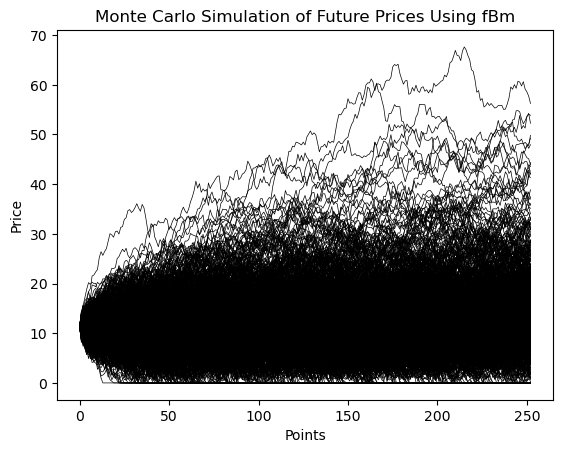

In [38]:
import matplotlib.pyplot as plt
from stochastic.processes.noise import FractionalGaussianNoise
import yfinance as yf
import numpy as np
import pandas as pd

df = yf.download('PFLT', start='2020-01-01', progress=False)
num_days = 252

num_simulations = 1000
simulation = np.zeros((num_days+1, num_simulations))

start = df["Adj Close"].values.tolist()[-1]

for i in range(num_simulations):
  H = np.random.uniform(low=.4-(np.e ** (-7.20 * np.log(np.log(np.log2(len(df)))) + 4.04)),
                        high=.4+(np.e ** (-7.33 * np.log(np.log(np.log2(len(df)))) + 4.21)))
  fgn = FractionalGaussianNoise(hurst=H,t=num_days)
  sim = fgn._sample_fractional_gaussian_noise(num_days)
  sim = sim.cumsum()
  sim = np.insert(sim, [0], 0)

  simulation[:, i] += sim

  ruin = np.where(sim < start*-1)[0].tolist()
  if len(ruin) >= 1:
    simulation[ruin[0]:,i] = start*-1
  
simulation = pd.DataFrame(simulation) + start

for i in range(num_simulations):
    plt.plot(simulation[i], lw=0.5,color="black")


plt.title(f"Monte Carlo Simulation of Future Prices Using fBm")
plt.xlabel("Points")
plt.ylabel("Price")
plt.show()

11.3100004196167
0.014330464071359973


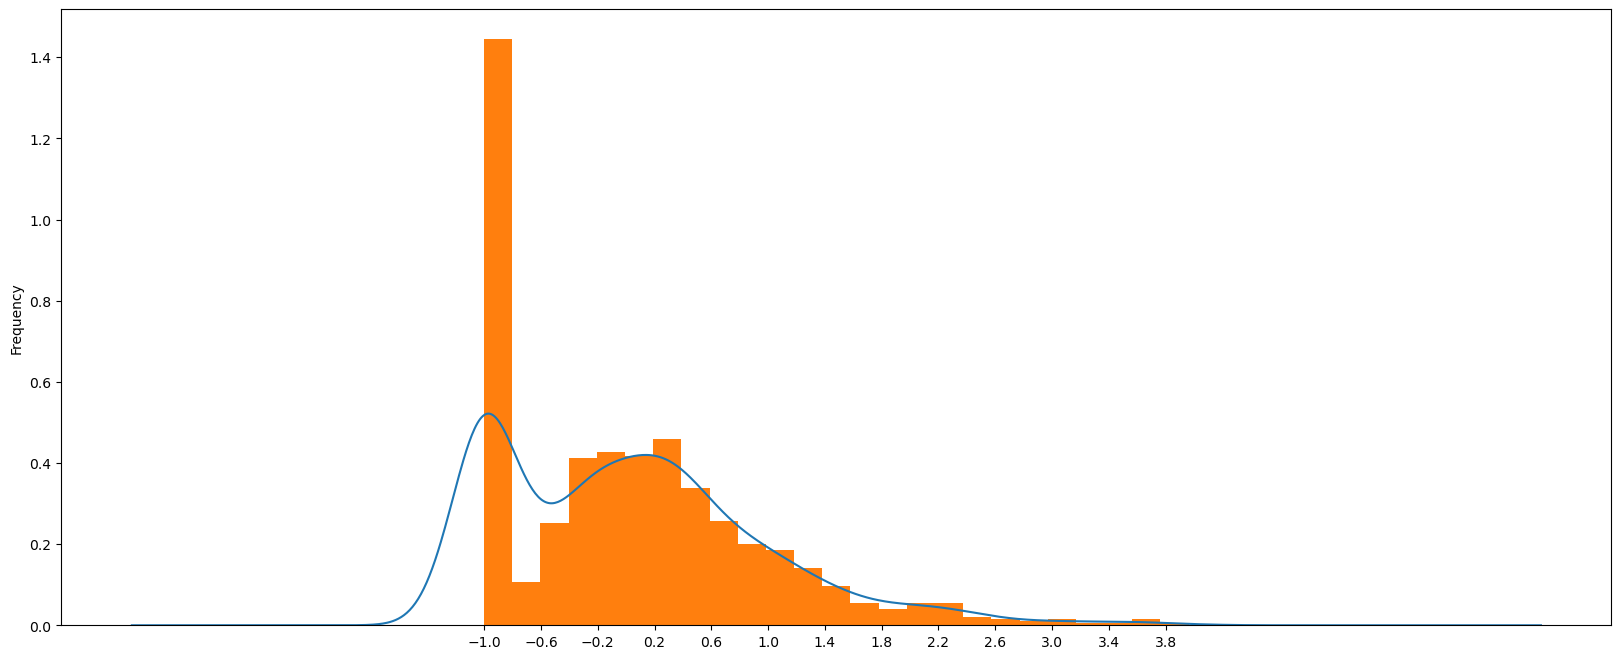

In [37]:
fig, ax = plt.subplots()

ret = (simulation.iloc[252]/start) - 1

print(start)
print(ret.mean())

ret.plot(kind="kde",figsize=(20,8))
ret.plot(kind="hist",bins=25,density=True)
plt.xticks(np.arange(-1,max(ret),step=.4))
plt.show()


In [367]:
import yfinance as yf
import datetime as dt

a = []

for i in range(30):
    day = dt.datetime.today() - pd.Timedelta(days=i)

    is_weekday = dt.datetime.isoweekday(day)

    if is_weekday == 6 or is_weekday == 7:
        continue

    start = day.strftime("%Y-%m-%d")

    if is_weekday == 5:
        end = (day + pd.Timedelta(days=3)).strftime("%Y-%m-%d")
    else:
        end = (day + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

    df = yf.download("SNOW", start=start, end=end, interval="1m",progress=False)["Adj Close"]
    
    a.append([start,df.skew(),df.kurtosis()])

pd.DataFrame(reversed(a),columns=["Date", "Skew", "Kurtosis"])

,Date,Skew,Kurtosis
0,2024-07-24,0.809778,-0.754612
1,2024-07-25,-0.658695,-0.874560
2,2024-07-26,0.336752,0.583664
3,2024-07-29,-0.589748,-0.682283
4,2024-07-30,1.144737,1.381376
5,2024-07-31,-0.378248,-0.842448
6,2024-08-01,1.176682,0.636115
7,2024-08-02,-0.679031,-0.447422
8,2024-08-05,-0.333589,0.343150
9,2024-08-06,-0.820835,0.365668


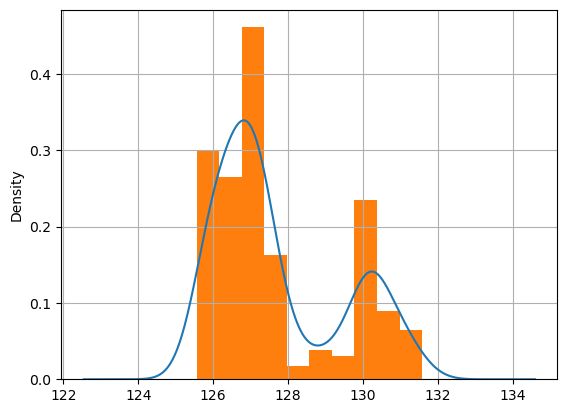

In [368]:
yf.download("SNOW", start=start, end=end, interval="1m",progress=False)["Adj Close"].plot(kind="kde")
yf.download("SNOW", start=start, end=end, interval="1m",progress=False)["Adj Close"].hist(density=True)
plt.show()

In [184]:
.5-np.e ** (-7.20 * np.log(np.log(np.log2(len(df)))) + 4.04)

0.2804149491403702

In [185]:
.5+np.e ** (-7.33 * np.log(np.log(np.log2(len(df)))) + 4.21)

0.7354321316838479

In [2]:
import pandas as pd
from mvdata import TickerData
from mvmodels import weighted_cost

inital = ["Total Revenues", "EBIT", "Income Tax Expense", "Depreciation & Amortization", 
            "Capital Expenditure", "Change In Net Working Capital", "Cash And Equivalents", 
            "Current Portion of LT Debt", "Total Common Shares Outstanding"]

ticker = TickerData("SBUX")

financials = pd.concat([ticker.get_financials("income-statement"),
                        ticker.get_financials("balance-sheet"),
                        ticker.get_financials("cash-flow-statement")],axis=0)

financials = financials.drop(["TTM", "Last Report"],axis=1)


weighted_cost("SBUX", financials)

KeyError: 0

In [ ]:

financials = financials.loc[financials.index.isin(inital)]
financials = financials[~financials.index.duplicated(keep="first")]

financials.columns = [int(val[4:]) for val in financials.columns.tolist()]
start = max(financials.columns.tolist())

financials = financials.dropna(axis=1).T 
financials = financials[inital]

if financials.index.values.tolist()[0] == start:
    financials = financials.iloc[::-1]

cash = financials.loc[financials.index == start,inital[-3]].values.tolist()[0]
debt = financials.loc[financials.index == start,inital[-2]].values.tolist()[0]
shares = financials.loc[financials.index == start,inital[-1]].values.tolist()[0]

financials = financials.drop(inital[6:],axis=1)

growth_rates = pd.DataFrame()
growth_rates.index = financials.index.values-start

growth_rates["Total Revenues"] = (financials["Total Revenues"]/financials["Total Revenues"].shift(1)).values-1
growth_rates["EBIT"] = (financials["EBIT"]/financials["Total Revenues"]).values

for col in inital[2:6]:
    growth_rates[col] = (financials[col]/financials["EBIT"]).values

growth_rates = growth_rates.T
financials = financials.T

In [2]:
import numpy as np

for i,k in zip(range(0,5,1), range(start,start+5,1)):
    years = [j for j in range(growth_rates.columns.tolist()[i],i+1,1)]
    growth_rates[i+1] = growth_rates[years].mean(axis=1)
    financials[k+1] = financials[k] * (1+growth_rates[i+1])

cols1 = financials.columns.tolist()
cols1 = np.array(cols1[cols1.index(start+1):])

financials = financials[cols1]
values = financials.T                  

unlevered_fcf = values[inital[1]]-values[inital[2]]+values[inital[3]]-values[inital[4]]-values[inital[5]]

cols2 = growth_rates.columns.tolist()
cols2 = np.array(cols2[cols2.index(1):])


In [28]:
tgv = .03
wacc = .15

tgvs = [tgv+(i*.005) for i in range(-2,10,1)]
waccs = [wacc+(i*.004) for i in range(-2,5,1)]

fair_values = np.zeros((len(tgvs),len(waccs)))

for i in range(len(tgvs)):
    for j in range(len(waccs)):
        pv_fcf = unlevered_fcf.values/((1+waccs[j])**cols2)

        tv = round((unlevered_fcf.values.tolist()[-1]*(1+waccs[j]))/(waccs[j]-tgvs[i]),1)
        pv_tv = round(tv/((1+waccs[j])**cols2.flatten().tolist()[-1]),1)

        enterprise_value = round(pv_tv + pv_fcf.sum(),1)
        fair_value = (enterprise_value+cash-debt)/shares

        fair_values[i,j] += round(fair_value,2)

fair_values = pd.DataFrame(fair_values,index=tgvs,columns=waccs)

fair_values

NameError: name 'unlevered_fcf' is not defined

In [ ]:
inital = ["Total Revenues", "EBIT", "Income Tax Expense", "Depreciation & Amortization", 
            "Capital Expenditure", "Change In Net Working Capital", "Cash And Equivalents", 
            "Current Portion of LT Debt", "Total Common Shares Outstanding"]

ticker = TickerData("SBUX")

financials = pd.concat([ticker.get_financials("income-statement"),
                        ticker.get_financials("balance-sheet"),
                        ticker.get_financials("cash-flow-statement")],axis=0)

financials = financials.drop(["TTM", "Last Report"],axis=1)